# Imports COCO dataset

In [1]:
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import skimage.io as io
import math
import random

# Imports MediaPipe

In [2]:
import scipy.io
import os
import mediapipe as mp
import cv2
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import shutil

# Imports for boths

In [3]:
import numpy as np

# Imports YOLO

In [4]:
from ultralytics import YOLO

# Load test images for model MediaPipe

In [5]:
N = 10
MEDIAPIPE_IMAGES_DIR = "./MEDIAPIPE_images"
output_folder= "./raw_images"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load annotations from COCO dataset

In [6]:
dataDir = './coco/'
dataType = 'val2017'
annFile_kps = '{}/annotations/person_keypoints_{}.json'.format(dataDir, dataType)
coco_kps = COCO(annFile_kps)

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!


# Get'person' category ID and get image ID with 'person' category and list to store true keypoints coordenates

In [7]:
catIds = coco_kps.getCatIds(catNms=['person'])
imgIds = coco_kps.getImgIds(catIds=catIds)[:10]

# Load and show the first 10 images with Keypoints and get keypoints coordenates

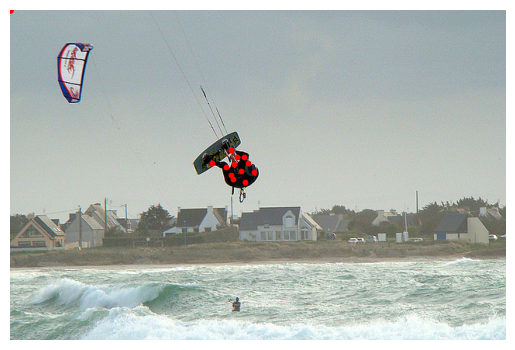

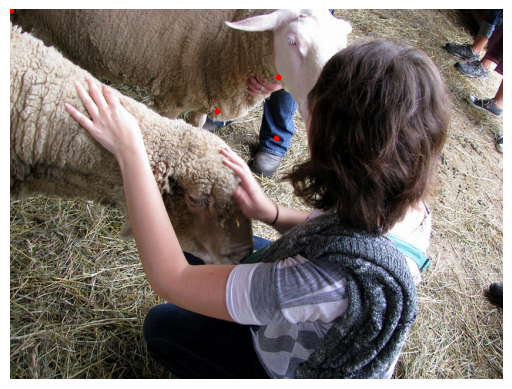

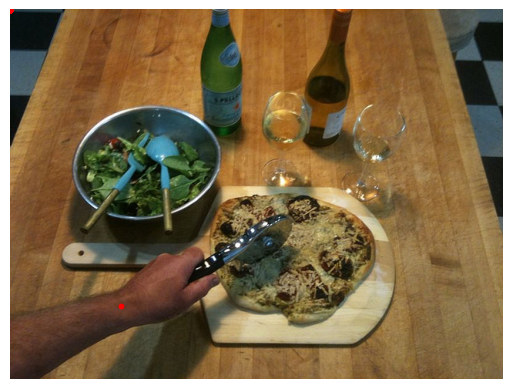

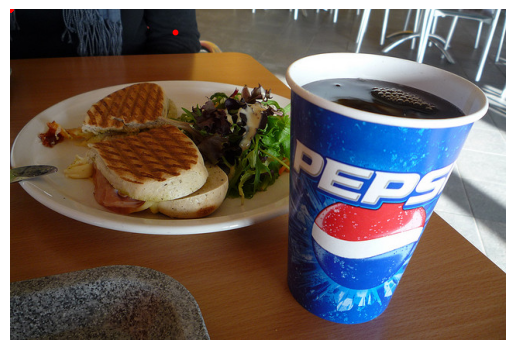

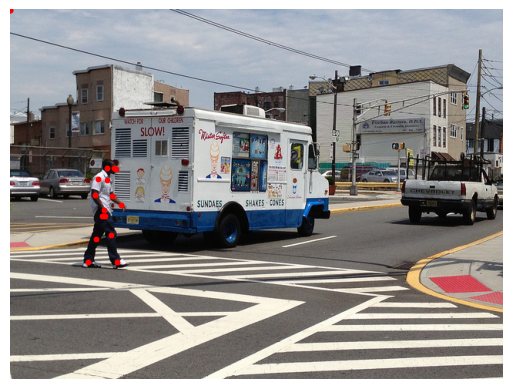

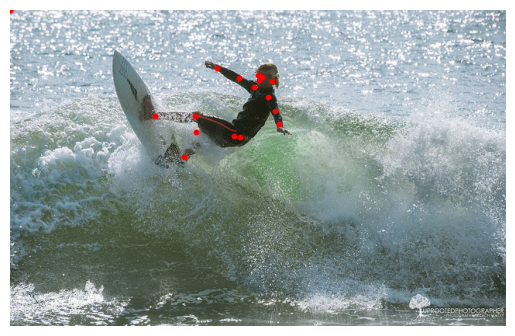

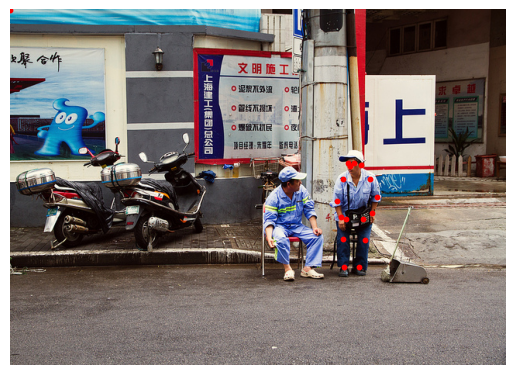

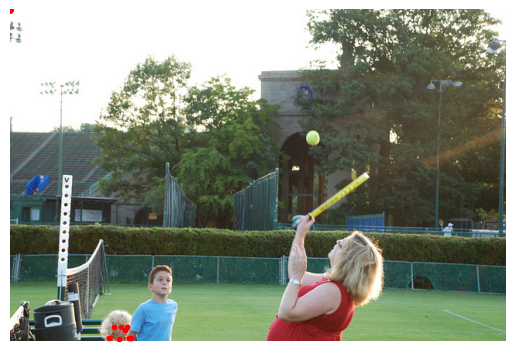

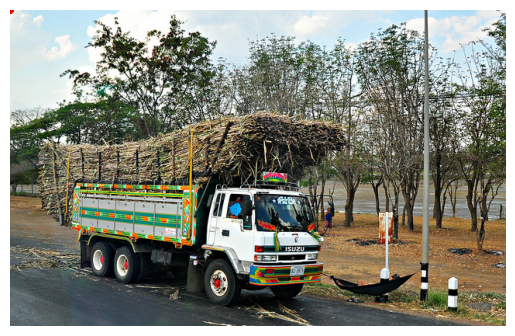

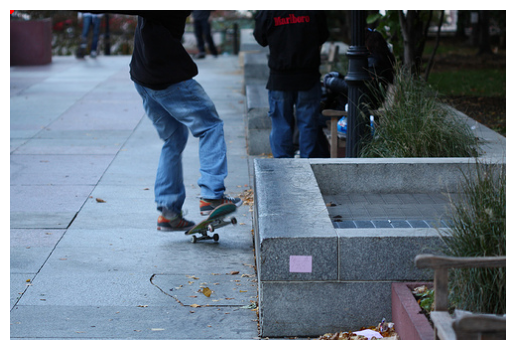

In [8]:
true_keypoints_list = []


for imgId in imgIds:
    
    img_info = coco_kps.loadImgs(imgId)[0]
    img_url = img_info['coco_url']
    
    
    I = io.imread(img_url)
    filename = img_url.split('/')[-1]
    output_path = os.path.join(output_folder, filename)
    
    
    io.imsave(output_path, I)
    
    
    #plt.imshow(I)
    #plt.axis('off')
    #plt.show()
    
    
    annIds = coco_kps.getAnnIds(imgIds=imgId, catIds=catIds, iscrowd=None)
    anns = coco_kps.loadAnns(annIds)
    keypoints_per_image = []

    
    
    if len(anns) > 1:
        
        ann = random.choice(anns)
        keypoints = ann['keypoints']
        if keypoints:
            keypoints = np.array(keypoints).reshape(-1, 3)  
            x = keypoints[:, 0]
            y = keypoints[:, 1]
            plt.scatter(x, y, s=10, c='r')
            keypoints_per_image.append(keypoints.tolist())
    elif len(anns) == 1:
       
        ann = anns[0]
        keypoints = ann['keypoints']
        if keypoints:
            keypoints = np.array(keypoints).reshape(-1, 3)  
            x = keypoints[:, 0]
            y = keypoints[:, 1]
            plt.scatter(x, y, s=10, c='r')
            keypoints_per_image.append(keypoints.tolist())
    
    plt.imshow(I)
    plt.axis('off')
    plt.show()

    true_keypoints_list.append(keypoints_per_image)

#print("True keypoints coordenates for the first image:")
#print(true_keypoints_list)

# Model MediaPipe

In [9]:
if not os.path.exists(MEDIAPIPE_IMAGES_DIR):
    os.makedirs(MEDIAPIPE_IMAGES_DIR)

def detect_pose(image_path):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
    
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    results = pose.process(image_rgb)

    # get predicted coordenates:
    predicted_keypoints = []
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            predicted_keypoints.append((landmark.x, landmark.y))
    # draw landmarks in image pose
    #if results.pose_landmarks:
        #mp_drawing = mp.solutions.drawing_utils
        #annotated_image = image.copy()
        #mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        #if not os.path.exists(MEDIAPIPE_IMAGES_DIR):
            #os.makedirs(MEDIAPIPE_IMAGES_DIR)
        
        # save image with landmarks inside dir'output'
        #file_path = os.path.join(MEDIAPIPE_IMAGES_DIR, f'{os.path.basename(image_path)}')
        #cv2.imwrite(file_path, annotated_image)
        #print("landmarks detected")
    #else:
        #pass
        #print("no landmarks detected")
    pose.close()
    return predicted_keypoints

predicted_keypoints_list_mp = []

files = filter(lambda file:file.endswith('.jpg'), os.listdir(output_folder))
for file in files:
    image_file = os.path.join(output_folder, file)
    predicted_keypoints = detect_pose(image_file)
    predicted_keypoints_list_mp.append(predicted_keypoints)
#print(predicted_keypoints_list_mp)
#detect_pose(image_file)

# Goal structure

In [10]:
#def getLandmarks(x):
    #yHat = {}
    #yHat["MediaPipe"] = getLandmarksMediaPipe(x)
    #yHat["Yolo"] = getLandmarksYolo(x)
    #return yHat

#def evaluateModels(y,yHat):
    #metrics = {}
    #metrics["MediaPipe"] = evaluateMediaPipe(y,yHat)
    #metrics["Yolo"] = evaluateYolo(y,yHat)
    #metrics
#def compareModels(metrics):
    #pass

In [11]:
#x,y = readDataset()
#yHat = getLandmarks(x)
#metrics = evaluateModels(y,yHat)
#compareModels(metrics)

# Model YOLO v8

In [12]:
model = YOLO("yolov8m-pose.pt") 

In [13]:
count = 0
results_list = []

files = filter(lambda file:file.endswith('.jpg'), os.listdir(output_folder))
for file in files:
    image_file = os.path.join(output_folder, file)
    #print("IMAGE FILE", image_file)
    
    results_yolo = model(source = image_file, show = False, conf= 0.5, save= True)
    results_list.append(results_yolo)
    #print("RESULTS LIST", results_list)
    count += 1
    if count >= N:
        break


 # Acess and print predicted keypoints MODEL YOLO
for i,result in enumerate(results_list):
    for r in result:
        #print(len(result))
        image_name = r.path.split('\\')[-1]
        #print(f"image {i+1} ({image_name})")
        xyn = r.keypoints.xyn
        for j, pose in enumerate(xyn):
            #print(f"pose {j+1}")
            for k, landmark in enumerate(pose):
                x, y = landmark
                #print(f"keypoints {k+1}:\t ({x},\t {y})")



image 1/1 C:\Users\bp111\OneDrive\Documentos\Code\YOLO_MediaPipe_COCO_dataset_comparison\raw_images\000000008211.jpg: 480x640 2 persons, 739.5ms
Speed: 1.7ms preprocess, 739.5ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\pose\predict9

image 1/1 C:\Users\bp111\OneDrive\Documentos\Code\YOLO_MediaPipe_COCO_dataset_comparison\raw_images\000000188439.jpg: 416x640 (no detections), 658.7ms
Speed: 0.0ms preprocess, 658.7ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs\pose\predict9

image 1/1 C:\Users\bp111\OneDrive\Documentos\Code\YOLO_MediaPipe_COCO_dataset_comparison\raw_images\000000311303.jpg: 448x640 1 person, 767.3ms
Speed: 0.0ms preprocess, 767.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\pose\predict9

image 1/1 C:\Users\bp111\OneDrive\Documentos\Code\YOLO_MediaPipe_COCO_dataset_comparison\raw_images\000000327701.jpg: 448x640 2 persons, 736.1ms
Speed: 0

# CALCULATE METRICS

# Convert the variables to a list of tuples where each element of the extern  list represents an image and each internal element represents the keypoints for that image

In [14]:
# Convert true_keypoints_list
true_keypoints_list_modified = []
for keypoints_per_image in true_keypoints_list:
    keypoints_image = []
    for keypoints in keypoints_per_image:
        keypoints_formatted = [(x, y) for x, y, _ in keypoints]
        keypoints_image.append(keypoints_formatted)
    true_keypoints_list_modified.append(keypoints_image)
#print(true_keypoints_list_modified)

In [15]:
# Convert predicted_keypoints_list_mp
predicted_keypoints_list_mp_modified = []
for keypoints_per_image in predicted_keypoints_list_mp:
    keypoints_image = []
    for x, y in keypoints_per_image:
        keypoints_image.append((x, y))
    predicted_keypoints_list_mp_modified.append([keypoints_image])
#print(predicted_keypoints_list_mp_modified)

# Create list to store predicted keypoints from YOLO model

In [16]:
aligned_results_list = []

for image_results in results_list:
    aligned_image_results = []
    for pose in image_results:
        aligned_pose = []
        if pose.keypoints is not None:
            for landmark in pose.keypoints.xyn:
                # check if exist at least 2 coordenates (x, y)
                if len(landmark) >= 2:
                    x_list = [float(x.item()) for x in landmark[0]]
                    y_list = [float(y.item()) for y in landmark[1]]
                    aligned_landmarks = [(x, y) for x, y in zip(x_list, y_list)]
                else:
                    aligned_landmarks = []  
                aligned_pose.append(aligned_landmarks)
        aligned_image_results.append(aligned_pose)
    aligned_results_list.append(aligned_image_results)

#print(aligned_results_list)

# Dictionary YOLO

In [17]:
predicted_keypoints_dict_yolo = {}

for i, keypoints_image in enumerate(aligned_results_list):
    predicted_keypoints_dict_yolo[f"image_{i+1}"] = {}
    for j, keypoints_pose in enumerate(keypoints_image):
        predicted_keypoints_dict_yolo[f"image_{i+1}"][f"pose_{j+1}"] = {}
        for k, keypoints in enumerate(keypoints_pose):
            predicted_keypoints_dict_yolo[f"image_{i+1}"][f"pose_{j+1}"][f"keypoints_{k+1}"] = keypoints

#print(predicted_keypoints_dict_yolo)

# COCO and MediaPipe Dictionary

In [18]:
true_keypoints_dict = {}
for i, keypoints_image in enumerate(true_keypoints_list_modified):
    true_keypoints_dict[f"image_{i+1}"] = {}
    for j, keypoints in enumerate(keypoints_image):
        true_keypoints_dict[f"image_{i+1}"][f"keypoints_{j+1}"] = keypoints
#print("true_keypoints_dict", true_keypoints_dict)

# Convert predicted_keypoints_list_mp_modified to an dictionary
predicted_keypoints_dict = {}
true_keypoints_dict_copy = true_keypoints_dict.copy()

# Add predicted values to predicted keypoints
for idx, (image_name, keypoints_dict) in enumerate(true_keypoints_dict_copy.items()):
    predicted_keypoints_dict[image_name] = {}
    
    if idx < len(predicted_keypoints_list_mp_modified):
        predicted_keypoints = predicted_keypoints_list_mp_modified[idx][0] 
        
        # Check if there are predicted keypoints
        if predicted_keypoints:
            for keypoint_key, keypoints in zip(keypoints_dict.keys(), predicted_keypoints):
                predicted_keypoints_dict[image_name][keypoint_key] = keypoints
        else:
            # If no predicted keypoints, keep the structure as it was
            predicted_keypoints_dict[image_name] = keypoints_dict

#print("predicted_keypoints_dict",predicted_keypoints_dict)
    

# Put same structure MediaPipe and COCO

In [19]:
predicted_keypoints_dict_fixed = {}

for image_name, keypoints_data in predicted_keypoints_dict.items():
    keypoints = keypoints_data['keypoints_1']
    if isinstance(keypoints, tuple):
        
        keypoints = [keypoints]
    predicted_keypoints_dict_fixed[image_name] = {'keypoints_1': keypoints}
#print(predicted_keypoints_dict_fixed)

# Compare if the 2 variables have the same structure

true_keypoints_structure = set()
predicted_keypoints_structure = set()


for image_data in true_keypoints_dict.values():
    for keypoints_data in image_data.values():
        true_keypoints_structure.add(type(keypoints_data))


for image_data in predicted_keypoints_dict_fixed.values():
    for keypoints_data in image_data.values():
        predicted_keypoints_structure.add(type(keypoints_data))

# Compare structures
if true_keypoints_structure == predicted_keypoints_structure:
    print(" variables have the same structure.")
else:
    print("variables not equals.")

 variables have the same structure.


# PE metric for MediaPipe

In [20]:
# check the length of the lists of true and predicted keypoints for all images and, if necessary, fill in the shorter lists with coordinates (0, 0).

def pad_keypoints(keypoints, target_length):
    # Fill the keypoint list with (0, 0) to reach the target length
    while len(keypoints) < target_length:
        keypoints.append((0, 0))
    return keypoints

for image_name, true_data in true_keypoints_dict.items():
    predicted_data = predicted_keypoints_dict_fixed.get(image_name)
    
    if predicted_data is None:
        raise ValueError(f"Image {image_name} has no predicted keypoints.")
    
    true_keypoints = true_data['keypoints_1']
    predicted_keypoints = predicted_data['keypoints_1']

####################################
    #print(f"Keypoints for {image_name}:")
    #print(" TRUE Keypoints:")
    #for idx, true_point in enumerate(true_keypoints):
        #print(f"Keypoint {idx+1}: {true_point}")
    
    #print("PREDICTED Keypoints:")
    #for idx, predicted_point in enumerate(predicted_keypoints):
        #print(f"Keypoint {idx+1}: {predicted_point}")
    ########################################
    true_length = len(true_keypoints)
    predicted_length = len(predicted_keypoints)
    
    # If the lengths are different, fill the shortest list with (0, 0)
    if true_length < predicted_length:
        true_keypoints = pad_keypoints(true_keypoints, predicted_length)
    elif predicted_length < true_length:
        predicted_keypoints = pad_keypoints(predicted_keypoints, true_length)
    
    # two lists have the same length
    #print(f"Length of true keypoints for {image_name}: {len(true_keypoints)}")
    #print(f"Length of keypoints predicted for {image_name}: {len(predicted_keypoints)}")


def calculate_pe(true_keypoints, predicted_keypoints):
    total_points = 0
    total_error_percentage = 0.0

    for true_image_name, true_image_data in true_keypoints.items():
        predicted_image_data = predicted_keypoints.get(true_image_name)

        if predicted_image_data is None:
            raise ValueError(f"Image {true_image_name} has no predicted keypoints.")

        true_points = true_image_data['keypoints_1']
        predicted_points = predicted_image_data['keypoints_1']

        # Checks if both lists have the same length
        if len(true_points) != len(predicted_points):
            raise ValueError(f"The lists of true and predicted points for the image {true_image_name} must be the same length.")

        # Calculate the error for each point and add it
        for true_point, predicted_point in zip(true_points, predicted_points):
            true_x, true_y = true_point
            predicted_x, predicted_y = predicted_point

            # ignore, if the true point is (0, 0)
            if true_x == 0 and true_y == 0:
                continue

            total_points += 1

            # Checks whether the predicted point was not detected 
            if predicted_x == 0 and predicted_y == 0:
                total_error_percentage += 1  # Adds 100% error 

            else:
                # Calculates the euclidean distance between points 
                error = ((true_x - predicted_x) ** 2 + (true_y - predicted_y) ** 2) ** 0.5

                # Calculates the percentage error
                error_percentage = error / max(true_x, true_y)
                total_error_percentage += error_percentage

    # Calculates the average percentage error
    mean_error_percentage = (total_error_percentage / total_points) * 100

    return mean_error_percentage

# Calculates PE metric
pe = calculate_pe(true_keypoints_dict, predicted_keypoints_dict_fixed)
#print("PE metric:", pe)


# Put the same structure YOLO and COCO

In [21]:
predicted_keypoints_dict_yolo_fixed = {}

# Structure YOLO results
for image_name, pose_data in predicted_keypoints_dict_yolo.items():
    keypoints_list = []
    for pose_keypoints_data in pose_data.values():
        for keypoints_data in pose_keypoints_data.values():
            if isinstance(keypoints_data, tuple):
                keypoints_data = [keypoints_data]
            keypoints_list.append({'keypoints_1': keypoints_data})
    predicted_keypoints_dict_yolo_fixed[image_name] = keypoints_list


true_keypoints_structure = set()
predicted_keypoints_structure_yolo = set()

# True structure (COCO)
for image_data in true_keypoints_dict.values():
    for keypoints_data in image_data.values():
        true_keypoints_structure.add(type(keypoints_data))

# Predicted structure (YOLO)
for image_data in predicted_keypoints_dict_yolo_fixed.values():
    for keypoints_data in image_data:
        for keypoint_data in keypoints_data.values():
            predicted_keypoints_structure_yolo.add(type(keypoint_data))

# Compare structures
#if true_keypoints_structure == predicted_keypoints_structure_yolo:
    #print(" variables has the same structure")
#else:
    #print("variables don't have the same structure")

# Function to pad keypoints with (0,0) to match target length
def pad_keypoints(keypoints, target_length):
    while len(keypoints) < target_length:
        keypoints.append((0, 0))
    return keypoints

# Iterate over the images and adjust the length of predicted YOLO keypoints if necessary
for image_name, true_data in true_keypoints_dict.items():
    predicted_data = predicted_keypoints_dict_yolo_fixed.get(image_name)
    
    if predicted_data is None:
        print(f"Image {image_name} does not have keypoints predicted by the YOLO model. ")
        continue
    
    true_keypoints = true_data['keypoints_1']
    predicted_keypoints_list = [pose_data['keypoints_1'] for pose_data in predicted_data]  # List of keypoints predicted
    
    true_length = len(true_keypoints)
    predicted_lengths = [len(keypoints) for keypoints in predicted_keypoints_list]
    max_predicted_length = max(predicted_lengths)
    
    # If the lengths are not equal, adjust the length of the predicted YOLO keypoints
    if true_length != max_predicted_length:
        predicted_keypoints_list = [pad_keypoints(keypoints, true_length) if len(keypoints) < true_length else keypoints for keypoints in predicted_keypoints_list]

    # Print true and predicted keypoints for each image along with their lengths
    #print(f"Image name: {image_name}")
    #print(f"Lenght of true Keypoints: {true_length}")
    #for pose_idx, keypoints in enumerate(predicted_keypoints_list, 1):
        #if keypoints: # Check if keypoints is not empty
            #predicted_length = len(keypoints)
            #print(f" Length of Predicted Keypoints for Pose {pose_idx}: {predicted_length}")
            #for idx, (x, y) in enumerate(keypoints):
                #print(f"Pose {pose_idx} - Keypoint {idx+1}: ({x}, {y})")
        #else:
            #print(f"Pose {pose_idx}: Nenhum keypoints previsto para esta pose.")
    #print()  # Add white line bettween images



# PE metric for YOLO

In [22]:

def euclidean_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Calculate PE metric for each pose
def calculate_PE(true_keypoints, predicted_keypoints):
    total_distance = 0
    num_keypoints = len(true_keypoints)
    for true_point, pred_point in zip(true_keypoints, predicted_keypoints):
        total_distance += euclidean_distance(true_point, pred_point)
    return total_distance / num_keypoints
    
all_PE_scores = []

# Calculate PE metric for each image
for image_name, true_data in true_keypoints_dict.items():
    predicted_data = predicted_keypoints_dict_yolo_fixed.get(image_name)
    
    if predicted_data is None:
        print(f" Image {image_name} does not have keypoints predicted by the YOLO model")
        continue
    
    true_keypoints = true_data['keypoints_1']
    predicted_keypoints_list = [pose_data['keypoints_1'] for pose_data in predicted_data]  # Lista de keypoints previstos
    
    true_length = len(true_keypoints)
    predicted_lengths = [len(keypoints) for keypoints in predicted_keypoints_list]
    max_predicted_length = max(predicted_lengths)
    
    # If the lengths are not the same, adjust the length of the predicted YOLO keypoints
    if true_length != max_predicted_length:
        predicted_keypoints_list = [pad_keypoints(keypoints, true_length) if len(keypoints) < true_length else keypoints for keypoints in predicted_keypoints_list]

    # Calculate the PE metric for each pose and print
    print(f"Image name: {image_name}")
    print(f"Lenght of true Keypoints: {true_length}")
    for pose_idx, predicted_keypoints in enumerate(predicted_keypoints_list, 1):
        if predicted_keypoints:  # Check if keypoints is not empty
            pe = calculate_PE(true_keypoints, predicted_keypoints)
            all_PE_scores.append(pe)  # Add PE value to list
            print(f"PE metric for Pose {pose_idx}: {pe}")
        else:
            print(f"Pose {pose_idx}: No keypoints provided for this pose")
    print()  # Add white line between each image
    
# Average all PE metrics
mean_PE = sum(all_PE_scores) / len(all_PE_scores)
print(f"Average of all PE metrics: {mean_PE}")

Image name: image_1
Lenght of true Keypoints: 17
PE metric for Pose 1: 250.49816005573885
PE metric for Pose 2: 250.52835177992475

Image name: image_2
Lenght of true Keypoints: 17
PE metric for Pose 1: 61.11192045311823

Image name: image_3
Lenght of true Keypoints: 17
PE metric for Pose 1: 24.179332877652033

Image name: image_4
Lenght of true Keypoints: 17
PE metric for Pose 1: 12.701087232009435
PE metric for Pose 2: 12.681170655094899

Image name: image_5
Lenght of true Keypoints: 17
PE metric for Pose 1: 251.75717939552646

Image name: image_6
Lenght of true Keypoints: 17
PE metric for Pose 1: 300.64917667273437

Image name: image_7
Lenght of true Keypoints: 17
PE metric for Pose 1: 482.57539514493936
PE metric for Pose 2: 482.57539514493936

Image name: image_8
Lenght of true Keypoints: 17
PE metric for Pose 1: 207.6851405041585
PE metric for Pose 2: 207.6851405041585

Image name: image_9
Lenght of true Keypoints: 17
PE metric for Pose 1: 0.0

Image name: image_10
Lenght of true

# Calculate basic statistics about the width and height of images and use these values to define 'image_width_or_height' , so that the distance threshold is best adapted to the images.

In [23]:
import os
import cv2

# Directory with input images
input_directory = "./raw_images"

# List to store image widths and heights
widths = []
heights = []

# Iterate over the images in the directory
for filename in os.listdir(input_directory):
    if filename.endswith(('.jpg')):  
        filepath = os.path.join(input_directory, filename)
        image = cv2.imread(filepath)
        if image is not None:
            height, width, _ = image.shape
            widths.append(width)
            heights.append(height)

# Calculate basic statistics
mean_width = sum(widths) / len(widths)
mean_height = sum(heights) / len(heights)
median_width = sorted(widths)[len(widths) // 2]
median_height = sorted(heights)[len(heights) // 2]
min_width = min(widths)
min_height = min(heights)
max_width = max(widths)
max_height = max(heights)


print("\nWidth Statistics:")
print(f"Average: {mean_width}")
print(f"Median: {median_width}")
print(f"Minim: {min_width}")
print(f"Max: {max_width}")

print("\nHeight Statistics:")
print(f"Average: {mean_height}")
print(f"Median: {median_height}")
print(f"Minim: {min_height}")
print(f"Max: {max_height}")

# Choose a value for image_width_or_height
image_width_or_height = mean_width  
print(f"\nImage_width_or_height value chosen: {image_width_or_height}")



Width Statistics:
Average: 626.0
Median: 640
Minim: 500
Max: 640

Height Statistics:
Average: 432.9
Median: 428
Minim: 333
Max: 480

Image_width_or_height value chosen: 626.0


# PCK for YOLO

In [24]:
image_width_or_height = 626.0

def calculate_PCK_YOLO(true_keypoints, predicted_keypoints, threshold):
    correct_predictions = 0
    total_predictions = len(true_keypoints)

    for true_point, pred_point in zip(true_keypoints, predicted_keypoints):
        if euclidean_distance(true_point, pred_point) <= threshold:
            correct_predictions += 1

    return correct_predictions / total_predictions

# Set the distance threshold for PCK
threshold = 0.1 * image_width_or_height 

# Calcular o PCK para cada imagem
all_PCK_scores = []

for image_name, true_data in true_keypoints_dict.items():
    predicted_data = predicted_keypoints_dict_yolo_fixed.get(image_name)
    
    if predicted_data is None:
        print(f"image {image_name} does not have keypoints predicted by the YOLO model")
        continue
    
    true_keypoints = true_data['keypoints_1']
    predicted_keypoints_list = [pose_data['keypoints_1'] for pose_data in predicted_data]  # List of predicted keypoints
    
    true_length = len(true_keypoints)
    predicted_lengths = [len(keypoints) for keypoints in predicted_keypoints_list]
    max_predicted_length = max(predicted_lengths)
    
    # If the lengths are not equal, adjust the length of the predicted YOLO keypoints
    if true_length != max_predicted_length:
        predicted_keypoints_list = [pad_keypoints(keypoints, true_length) if len(keypoints) < true_length else keypoints for keypoints in predicted_keypoints_list]

    # calculate the PCK for each pose
    for pose_idx, predicted_keypoints in enumerate(predicted_keypoints_list, 1):
        if predicted_keypoints:  # Check if keypoints is not empty
            pck = calculate_PCK_YOLO(true_keypoints, predicted_keypoints, threshold)
            all_PCK_scores.append(pck)  # Add the PCK value to the list
            print(f"PCK for Pose {pose_idx} in the image {image_name}: {pck}")
        else:
            print(f"Pose {pose_idx} in the image {image_name}:No keypoints provided for this pose")

# Calculate the average of all PCK values 
mean_PCK = sum(all_PCK_scores) / len(all_PCK_scores)
print(f"Average of all PCK metrics: {mean_PCK}")


PCK for Pose 1 in the image image_1: 0.29411764705882354
PCK for Pose 2 in the image image_1: 0.29411764705882354
PCK for Pose 1 in the image image_2: 0.8235294117647058
PCK for Pose 1 in the image image_3: 0.9411764705882353
PCK for Pose 1 in the image image_4: 0.9411764705882353
PCK for Pose 2 in the image image_4: 0.9411764705882353
PCK for Pose 1 in the image image_5: 0.11764705882352941
PCK for Pose 1 in the image image_6: 0.058823529411764705
PCK for Pose 1 in the image image_7: 0.058823529411764705
PCK for Pose 2 in the image image_7: 0.058823529411764705
PCK for Pose 1 in the image image_8: 0.5294117647058824
PCK for Pose 2 in the image image_8: 0.5294117647058824
PCK for Pose 1 in the image image_9: 1.0
PCK for Pose 1 in the image image_10: 1.0
Average of all PCK metrics: 0.542016806722689


# PCK metric for MediaPipe

In [25]:
def calculate_PCK_MEDIAPIPE(true_keypoints, predicted_keypoints_list, threshold):
    all_PCK_scores = [] 

    for image_name, true_data in true_keypoints.items():
        predicted_data = predicted_keypoints_list.get(image_name)
        
        if predicted_data is None:
            print(f"Image {image_name} does not have predicted keypoints.")
            continue
        
        true_keypoints = true_data['keypoints_1']
        predicted_keypoints = predicted_data['keypoints_1']
        
        true_length = len(true_keypoints)
        predicted_length = len(predicted_keypoints)
        
        # If the lengths are not equal, fill the predicted keypoints with (0, 0) until they reach the same length as the true keypoints
        if true_length != predicted_length:
            predicted_keypoints = pad_keypoints(predicted_keypoints, true_length)

        # Calculates the PCK for the current image
        correct_predictions = 0
        total_predictions = len(true_keypoints)

        for true_point, pred_point in zip(true_keypoints, predicted_keypoints):
            if euclidean_distance(true_point, pred_point) <= threshold:
                correct_predictions += 1
        
        pck = correct_predictions / total_predictions
        all_PCK_scores.append(pck)
        print(f"PCK for image {image_name}: {pck}")

    # Calculates the average of all PCK values
    mean_PCK = sum(all_PCK_scores) / len(all_PCK_scores)
    print(f"Average of all PCK metrics: {mean_PCK}")

    return mean_PCK


threshold = 0.1 * image_width_or_height  

# Calculate PCK for each pose across all images
pck_media_pipe = calculate_PCK_MEDIAPIPE(true_keypoints_dict, predicted_keypoints_dict_fixed, threshold)
print("PCK metric:", pck_media_pipe)


PCK for image image_1: 0.29411764705882354
PCK for image image_2: 1.0
PCK for image image_3: 1.0
PCK for image image_4: 1.0
PCK for image image_5: 1.0
PCK for image image_6: 0.058823529411764705
PCK for image image_7: 0.058823529411764705
PCK for image image_8: 1.0
PCK for image image_9: 1.0
PCK for image image_10: 1.0
Average of all PCK metrics: 0.7411764705882352
PCK metric: 0.7411764705882352


# MPJPE metric for MediaPipe

In [29]:
def calculate_MPJPE_MEDIAPIPE(true_keypoints, predicted_keypoints_list):
    all_MPJPE_scores = [] 

    for image_name, true_data in true_keypoints.items():
        predicted_data = predicted_keypoints_list.get(image_name)
        
        if predicted_data is None:
            print(f"Image {image_name} does not have predicted keypoints.")
            continue
        
        true_keypoints = true_data['keypoints_1']
        predicted_keypoints = predicted_data['keypoints_1']
        
        true_length = len(true_keypoints)
        predicted_length = len(predicted_keypoints)
        
        # If the lengths are not equal, fill the predicted keypoints with (0, 0) until they reach the same length as the true keypoints
        if true_length != predicted_length:
            predicted_keypoints = pad_keypoints(predicted_keypoints, true_length)

        # Calculates position error for each joint
        MPJPE_per_joint = []  # List to store position errors for each joint
        
        for true_point, pred_point in zip(true_keypoints, predicted_keypoints):
            
            if true_point == (0, 0):
                continue

            # Calculates the Euclidean distance between true and predicted points
            distance = euclidean_distance(true_point, pred_point)
            MPJPE_per_joint.append(distance)
        
        # check erros to calculate the average
        if MPJPE_per_joint:
            # Calculates the MPJPE for the current image (average of position errors for all joints)
            MPJPE = np.mean(MPJPE_per_joint)
            all_MPJPE_scores.append(MPJPE)
            print(f"MPJPE for image {image_name}: {MPJPE}")
        else:
            print(f"No true keypoints found in image {image_name}. Skipping calculation.")

    # Checks for valid values to calculate the average
    if all_MPJPE_scores:
        # Calculates the average of all MPJPE values
        mean_MPJPE = np.mean(all_MPJPE_scores)
        print(f"Average of all MPJPE metrics: {mean_MPJPE}")
        return mean_MPJPE
    else:
        print("No valid MPJPE scores found.")
        return None

# Calculates MPJPE for each pose across all images
mpjpe = calculate_MPJPE_MEDIAPIPE(true_keypoints_dict, predicted_keypoints_dict_fixed)
if mpjpe is not None:
    print("MPJPE metric:", mpjpe)
else:
    print("Unable to calculate MPJPE due to invalid scores.")


MPJPE for image image_1: 354.78277973870905
MPJPE for image image_2: 0.0
MPJPE for image image_3: 0.0
MPJPE for image image_4: 0.0
MPJPE for image image_5: 0.0
MPJPE for image image_6: 319.4688723150592
MPJPE for image image_7: 512.7166911249631
MPJPE for image image_8: 0.0
No true keypoints found in image image_9. Skipping calculation.
No true keypoints found in image image_10. Skipping calculation.
Average of all MPJPE metrics: 148.3710428973414
MPJPE metric: 148.3710428973414


# MPJPE metric for YOLO

In [32]:
def calculate_MPJPE(true_keypoints, predicted_keypoints):
    total_error = 0
    total_joints = 0

    for true_point, pred_point in zip(true_keypoints, predicted_keypoints):
        
        error = euclidean_distance(true_point, pred_point)
        total_error += error
        total_joints += 1

    # calculates the average position errors for all joints
    mpjpe = total_error / total_joints
    return mpjpe


all_MPJPE_scores = []

for image_name, true_data in true_keypoints_dict.items():
    predicted_data = predicted_keypoints_dict_yolo_fixed.get(image_name)
    
    if predicted_data is None:
        print(f"image {image_name} does not have keypoints predicted by the YOLO model")
        continue
    
    true_keypoints = true_data['keypoints_1']
    predicted_keypoints_list = [pose_data['keypoints_1'] for pose_data in predicted_data]  # List of predicted keypoints
    
    true_length = len(true_keypoints)
    predicted_lengths = [len(keypoints) for keypoints in predicted_keypoints_list]
    max_predicted_length = max(predicted_lengths)
    
    # If the lengths are not the same, adjust the length of the keypoints predicted by YOLO
    if true_length != max_predicted_length:
        predicted_keypoints_list = [pad_keypoints(keypoints, true_length) if len(keypoints) < true_length else keypoints for keypoints in predicted_keypoints_list]

    # Calculate the MPJPE for each pose
    for pose_idx, predicted_keypoints in enumerate(predicted_keypoints_list, 1):
        if predicted_keypoints:  
            mpjpe = calculate_MPJPE(true_keypoints, predicted_keypoints)
            all_MPJPE_scores.append(mpjpe)  # Add MPJPE value to the list
            print(f"MPJPE for Pose {pose_idx} in the image {image_name}: {mpjpe}")
        else:
            print(f"Pose {pose_idx} in the image {image_name}: No keypoints were provided for this pose")

# Calculate the average of all MPJPE values
mean_MPJPE = np.mean(all_MPJPE_scores)
print(f"Average of all MPJPE: {mean_MPJPE}")


MPJPE para a Pose 1 na imagem image_1: 250.49816005573885
MPJPE para a Pose 2 na imagem image_1: 250.52835177992475
MPJPE para a Pose 1 na imagem image_2: 61.11192045311823
MPJPE para a Pose 1 na imagem image_3: 24.179332877652033
MPJPE para a Pose 1 na imagem image_4: 12.701087232009435
MPJPE para a Pose 2 na imagem image_4: 12.681170655094899
MPJPE para a Pose 1 na imagem image_5: 251.75717939552646
MPJPE para a Pose 1 na imagem image_6: 300.64917667273437
MPJPE para a Pose 1 na imagem image_7: 482.57539514493936
MPJPE para a Pose 2 na imagem image_7: 482.57539514493936
MPJPE para a Pose 1 na imagem image_8: 207.6851405041585
MPJPE para a Pose 2 na imagem image_8: 207.6851405041585
MPJPE para a Pose 1 na imagem image_9: 0.0
MPJPE para a Pose 1 na imagem image_10: 0.060425526181803725
Média de todos os MPJPE: 181.76341971044118
